In [1]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 

In [2]:
import torch
pytorch_version = "torch-" + torch.__version__ + ".html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 11.2 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 14.7 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 14.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 15.7 MB/s 
     |████████████████████████████████| 407 kB 12.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=b5a738d4911f49db768a2f8f94ef51c7d75031166bd8b17724fd024c92da1e74
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [3]:
!pip install deepchem
import deepchem as dc

     |████████████████████████████████| 608 kB 16.0 MB/s 
     |████████████████████████████████| 22.5 MB 1.6 MB/s 


In [4]:
import pandas as pd
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import rdmolops, Draw
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # source of data: http://moleculenet.ai/datasets-1
# smile_path = 'drive/MyDrive/Graph_Data/raw/'
# smile_name = 'tox21.csv'

# smile = pd.read_csv(os.path.join(smile_path, smile_name))
# smile.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [6]:
smile_path = 'drive/MyDrive/Graph_Data_3/raw/'
smile_name = 'tox21_PREPROCESSED.csv'

smile = pd.read_csv(os.path.join(smile_path, smile_name))
smile.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,smiles
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCN1C(=O)NC(c2ccccc2)C1=O
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O


In [7]:
smile.shape

(7812, 13)

In [ ]:
# smiles = "C"
# featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
# out = featurizer.featurize(smiles)
# print(type(out[0]))
# if type(out[0]) is np.ndarray:
#   print("yo")

Failed to featurize datapoint 0, C. Appending empty array
Exception message: More than one atom should be present in the molecule for this featurizer to work.


<class 'numpy.ndarray'>
yo


In [ ]:
# #Setting weights for loss function
# weight_for_one = sum(smile['p_np']== 0.0) / len(smile)
# weight_for_zero = sum(smile['p_np'] == 1.0) / len(smile)
# weights = torch.tensor([weight_for_zero, weight_for_one])

# print('Weight for positive prediction: ', weight_for_one)
# print('Weight for negative prediction: ', weight_for_zero)

KeyError: ignored

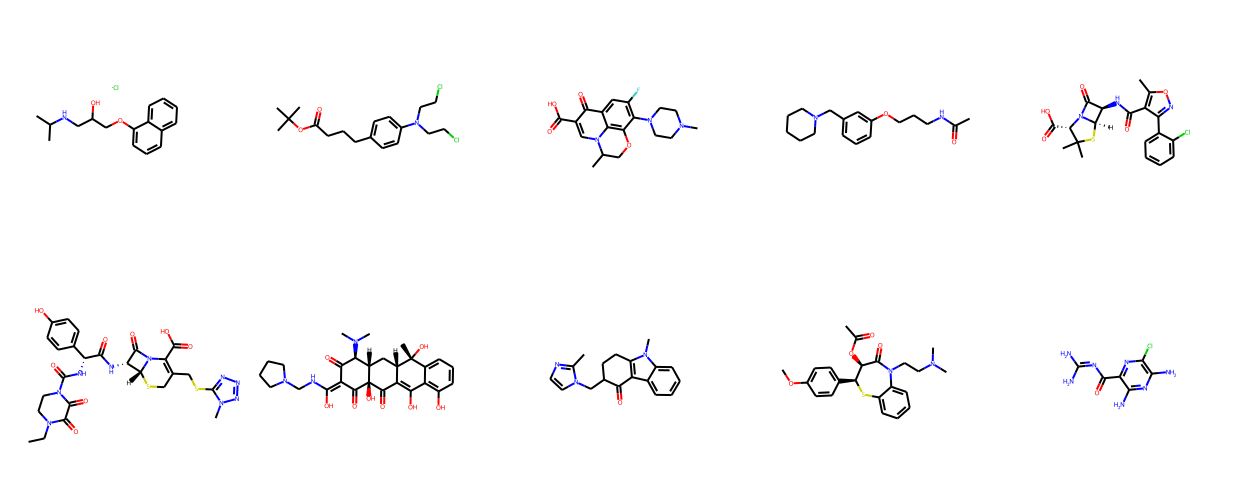

In [ ]:
# first_ten = smile["smiles"][:10].values
# first_ten = [Chem.MolFromSmiles(smiles) for smiles in first_ten]
# grid = Draw.MolsToGridImage(first_ten, molsPerRow=5, subImgSize=(250,250))
# grid

In [8]:
from deepchem.feat.base_classes import MolecularFeaturizer

In [9]:
class MoleculeDataset(Dataset):
  def __init__(self, root, transform=None, pre_transform=None):
    super(MoleculeDataset, self).__init__(root, transform, pre_transform)

  @property
  def raw_file_names(self):
    return 'tox21_PREPROCESSED.csv'

  @property
  def processed_file_names(self):
    return 'not_implemented.pt'

  def download(self):
    pass

  def process(self):
    self.data = pd.read_csv(self.raw_paths[0])
    #self.data.drop(labels=['num', 'name'], axis=1, inplace=True)
    #self.corrupted_molecules = 0
    self.count = 0
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
      try: #stan zero
        molecule = Chem.MolFromSmiles(mol["smiles"])
        out = featurizer.featurize(mol["smiles"])
      except:
        #print(index)
        #self.corrupted_molecules += 1
        continue
      if type(out[0]) is not np.ndarray:
        
        # node_features = self._get_node_features(molecule)
        # edge_features = self._get_edge_features(molecule)
        # edge_index = self._get_adjecency_info(molecule)
        
        node_features = torch.tensor(out[0].node_features, dtype=torch.float)
        edge_features = torch.tensor(out[0].edge_features, dtype=torch.float)
        edge_index = torch.tensor(out[0].edge_index, dtype=torch.long)

      #   'NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
      #  'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53',
      #  'smiles'

        label = self._get_labels(mol['NR-AR'])

        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=label, smiles=mol['smiles'])
        #torch.save(data, os.path.join(self.processed_dir, f'data_{index-self.corrupted_molecules}.pt'))
        torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))
      else:
        self.count += 1
      # except:
      #   print(index)
      #   self.corrupted_molecules += 1
      #   pass
    # print('Number of corrupted molecules: ', self.corrupted_molecules)
    print("End:", self.count)

  def _get_node_features(self, molecule):

    all_node_features = []

    for atom in molecule.GetAtoms():
      node_fts = []
      node_fts.append(atom.GetAtomicNum()) #atomic number
      node_fts.append(atom.GetFormalCharge()) #formal charge
      node_fts.append(atom.GetChiralTag()) #chiral tag
      node_fts.append(atom.GetIsAromatic()) #is aromatic
      all_node_features.append(node_fts)

    all_node_features = np.asarray(all_node_features)
    return torch.tensor(all_node_features, dtype=torch.float)


  def _get_edge_features(self, molecule):

    all_edge_features = []

    for bond in molecule.GetBonds():
      edge_fts = []
      edge_fts.append(bond.GetBondTypeAsDouble()) #bond type as double
      edge_fts.append(bond.GetStereo()) #bond stereo
      all_edge_features.append(edge_fts)

    all_edge_features = np.asarray(all_edge_features)
    return torch.tensor(all_edge_features, dtype=torch.float)

  def _get_adjecency_info(self, molecule):
    edge_indices = []
    for bond in molecule.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]

    edge_indices = torch.tensor(edge_indices)
    edge_indices = edge_indices.t().to(torch.long).view(2, -1)
    return edge_indices

  def _get_labels(self, label):
    label = np.asarray([[label]])
    res = torch.tensor(label, dtype=torch.int64)
    return res

  def len(self):
    return self.data.shape[0]

  def get(self, idx):
    data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [10]:
data_folder = 'drive/MyDrive/Graph_Data_3/'
data = MoleculeDataset(root=data_folder)

Processing...
100%|██████████| 7812/7812 [02:11<00:00, 59.57it/s]

End: 0



Done!


In [12]:
print('Edge indexes in coo format: ', data[0].edge_index.t()) #edge indexes in coo format
print('\n Node features: ', data[0].x) #node features matrix
print('\n Edge features: ', data[0].edge_attr) #edge features matrix
print('\n Label: ', data[0].y) # label

Edge indexes in coo format:  tensor([[ 0, 10],
        [10,  0],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [12,  4],
        [ 4, 12],
        [ 4,  5],
        [ 5,  4],
        [ 5, 15],
        [15,  5],
        [15,  1],
        [ 1, 15],
        [ 1,  7],
        [ 7,  1],
        [ 7,  2],
        [ 2,  7],
        [ 2, 13],
        [13,  2],
        [ 2,  3],
        [ 3,  2],
        [ 2,  8],
        [ 8,  2],
        [ 7,  6],
        [ 6,  7],
        [ 6, 14],
        [14,  6],
        [14,  9],
        [ 9, 14],
        [ 9, 12],
        [12,  9],
        [14, 15],
        [15, 14]])

 Node features:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1

In [11]:
data.num_features

30

In [13]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GATv2Conv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 256

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        torch.manual_seed(42)

        self.initial_conv = GATv2Conv(data.num_features, embedding_size)
        self.conv1 = GATv2Conv(embedding_size, embedding_size)
        self.conv2 = GATv2Conv(embedding_size, embedding_size)
        self.conv3 = GATv2Conv(embedding_size, embedding_size)
        self.conv4 = GATv2Conv(embedding_size, embedding_size)


        self.linear1 = Linear(embedding_size*2, embedding_size)
        self.linear2 = Linear(embedding_size, 128)
        self.linear3 = Linear(128, 1)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv4(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Output 
        hidden = self.linear1(hidden).relu()
        hidden = F.dropout(hidden, p=0.4, training=self.training)

        hidden = self.linear2(hidden).relu()
        hidden = F.dropout(hidden, p=0.4, training=self.training)

        hidden = self.linear3(hidden)
        out = torch.sigmoid(hidden)

        return out, hidden


In [14]:
model = GAT()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GAT(
  (initial_conv): GATv2Conv(30, 256, heads=1)
  (conv1): GATv2Conv(256, 256, heads=1)
  (conv2): GATv2Conv(256, 256, heads=1)
  (conv3): GATv2Conv(256, 256, heads=1)
  (conv4): GATv2Conv(256, 256, heads=1)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  709121


In [15]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Root mean squared error
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

In [17]:
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
#Data split
train_percent = 0.8
validate_percent = 0.1
train_index = int(train_percent*len(data))
valid_index = int(validate_percent*len(data))

data = data.shuffle()
train_dataset = data[:train_index]
valid_dataset = data[train_index:(train_index+valid_index)]
test_dataset = data[(train_index+valid_index):]

print('Length of train dataset: ', len(train_dataset))
print('Length of validation dataset: ', len(valid_dataset))
print('Length of test dataset: ', len(test_dataset))

Length of train dataset:  6249
Length of validation dataset:  781
Length of test dataset:  782


In [19]:
# Wrap data in a data loader

data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


# data_size = len(data)
# NUM_GRAPHS_PER_BATCH = 64
# loader = DataLoader(data[:int(data_size * 0.8)], 
#                     batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
# test_loader = DataLoader(data[int(data_size * 0.8):], 
#                          batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(epoch):
    for batch in train_loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      loss = torch.sqrt(loss_fn(pred, batch.y.float()))  # could get rid of sqrt     
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding

def valid(epoch):
  for batch in valid_loader:
    batch.to(device)
    optimizer.zero_grad() 
    # Passing the node features and the connection info
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
    loss = torch.sqrt(loss_fn(pred, batch.y.float()))  # could get rid of sqrt     
    loss.backward()  
    # Update using the gradients
    optimizer.step()   
  return loss, embedding

print("Starting training...")
losses = []
losses_valid = []
for epoch in range(100):
    model.train()
    loss, h = train(epoch=epoch)
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(f"Epoch {epoch} | Train Loss {loss}")

    model.eval()
    if epoch % 5 == 0:
      loss, h = valid(epoch=epoch)
      loss = loss.detach().cpu().numpy()
      losses_valid.append(loss)
      print(f"Epoch {epoch} | Valid Loss {loss}")

print("Done")

Starting training...
Epoch 0 | Train Loss 0.32186034321784973
Epoch 0 | Valid Loss 0.23504041135311127
Epoch 1 | Train Loss 0.4585118293762207
Epoch 2 | Train Loss 0.4220723509788513
Epoch 3 | Train Loss 0.4050545394420624
Epoch 4 | Train Loss 0.18652354180812836
Epoch 5 | Train Loss 0.33508309721946716
Epoch 5 | Valid Loss 0.3571367561817169
Epoch 6 | Train Loss 0.25653669238090515
Epoch 7 | Train Loss 0.2039749026298523
Epoch 8 | Train Loss 0.4773173928260803
Epoch 9 | Train Loss 0.1547539085149765
Epoch 10 | Train Loss 0.4972645342350006
Epoch 10 | Valid Loss 0.5570051074028015
Epoch 11 | Train Loss 0.32194212079048157
Epoch 12 | Train Loss 0.3391062319278717
Epoch 13 | Train Loss 0.4038020670413971
Epoch 14 | Train Loss 0.3850012421607971
Epoch 15 | Train Loss 0.32598936557769775
Epoch 15 | Valid Loss 0.6300954818725586
Epoch 16 | Train Loss 0.2644111216068268
Epoch 17 | Train Loss 0.398569256067276
Epoch 18 | Train Loss 0.27610692381858826
Epoch 19 | Train Loss 0.45487943291664124

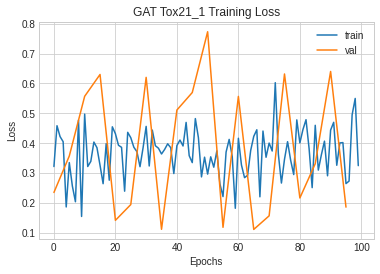

In [20]:
import seaborn as sns
losses_float = [float(loss) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses)] 

losses_valid_float = [float(loss) for loss in losses_valid] 
loss_indices_valid = [i for i,l in enumerate(losses_valid)] 

loss_indices_valid = [x * 5 for x in loss_indices_valid]

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

fig = plt.figure()
ax = plt.axes()

plt.plot(loss_indices, losses_float, label='train');
plt.plot(loss_indices_valid, losses_valid_float, label='val')
plt.title("GAT Tox21_1 Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

# print(type(losses_float))
# plt = sns.lineplot(list(range(200)), losses)
# plt

In [21]:
import pandas as pd 

# Analyze the results for one batch
#test_batch = next(iter(test_loader))
df = pd.DataFrame()
column_names = ["y_real", "y_pred"]
df = pd.DataFrame(columns = column_names)

for test_batch in test_loader:
  with torch.no_grad():
      test_batch.to(device)
      pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
      out = (pred>0.5).float()

      xtra = {"y_real": test_batch.y.tolist(),"y_pred": out.tolist()}
      df = df.append(pd.DataFrame(xtra))
      

      # df["y_real"] = test_batch.y.tolist()
      
      # df["y_pred"] = out.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])


In [22]:
from sklearn.metrics import f1_score
print(f1_score(df["y_real"], df["y_pred"]))

0.34285714285714286


In [23]:
from sklearn.metrics import accuracy_score
print(accuracy_score(df["y_real"], df["y_pred"]))

0.9705882352941176


In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df["y_real"], df["y_pred"])

0.6097866077998528

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

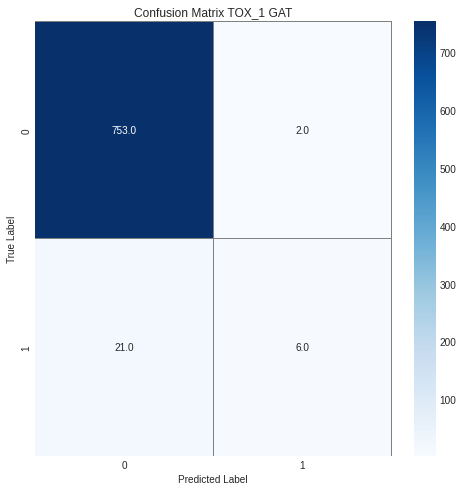

In [26]:
cm = confusion_matrix(df["y_real"], df["y_pred"])

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.title("Confusion Matrix TOX_1 GAT")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
report = classification_report(y_true=df["y_real"], y_pred=df["y_pred"], target_names=["0", "1"])
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       755
           1       0.75      0.22      0.34        27

    accuracy                           0.97       782
   macro avg       0.86      0.61      0.66       782
weighted avg       0.97      0.97      0.96       782



In [28]:
import pandas as pd 

# Analyze the results for one batch
#test_batch = next(iter(test_loader))
df = pd.DataFrame()
column_names = ["y_real", "y_pred"]
df = pd.DataFrame(columns = column_names)

for test_batch in train_loader:
  with torch.no_grad():
      test_batch.to(device)
      pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
      out = (pred>0.5).float()

      xtra = {"y_real": test_batch.y.tolist(),"y_pred": out.tolist()}
      df = df.append(pd.DataFrame(xtra))
      

      # df["y_real"] = test_batch.y.tolist()
      
      # df["y_pred"] = out.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
df

,y_real,y_pred
0,1,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
...,...,...
100,0,0.0
101,0,0.0
102,0,0.0
103,0,0.0


In [29]:
report = classification_report(y_true=df["y_real"], y_pred=df["y_pred"], target_names=["0", "1"])
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5997
           1       0.76      0.23      0.36       252

    accuracy                           0.97      6249
   macro avg       0.86      0.62      0.67      6249
weighted avg       0.96      0.97      0.96      6249

